In [ ]:
%load_ext nb_black

In [115]:
import warnings

warnings.filterwarnings("ignore")

# Basic Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split

# Modelling
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

# Balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Binning
import woeBinningPandas

Data: https://www.kaggle.com/wordsforthewise/lending-club

In [10]:
# Read data
accepted = pd.read_csv("accepted_2007_to_2018Q4.csv", low_memory=False)
rejected = pd.read_csv("rejected_2007_to_2018Q4.csv", low_memory=False)

## KGB Model

In [208]:
# Sample 100k obs. for easy processing
accepted_small = accepted.sample(n=100000, random_state=7)
accepted_small.reset_index(drop=True, inplace=True)

In [209]:
# Create Default Flag
accepted_small["target"] = accepted_small["loan_status"].apply(
    lambda x: 1 if x == "Charged Off" else (0 if x == "Fully Paid" else 2)
)

In [210]:
# Remove Current and Missings
accepted_small = accepted_small.loc[accepted_small["target"] != 2]
accepted_small.shape

(59570, 152)

In [211]:
pd.crosstab(accepted_small["target"], accepted_small["loan_status"])

loan_status,Charged Off,Fully Paid
target,,
0,0,47629
1,11941,0


The dataset is imbalanced

In [212]:
# Keep only 2 explanatory variables for quick an dirty PD model
df = accepted_small[["id", "target", "loan_amnt", "addr_state"]]

In [213]:
# Q&D Bucketing

#Loan Amount
df["loan_amnt2"] = df["loan_amnt"].apply(
    lambda x: "<=1k"
    if (x <= 1000)
    else ("1-10k" if (x > 1000 and x <= 10000) else ">10k")
)

In [214]:
#State
binning = woeBinningPandas.woe_binning (df, "target", "addr_state", 0.1, 0.1, 50, 100, "bad")

In [215]:
badstates = binning["Group_1"][:25].tolist()
california = ['CA']
goodstates = binning["Group_1"][27:].tolist()

In [216]:
df["addr_state2"] = df["addr_state"].apply(
    lambda x: "California"
    if (x == "CA")
    else ("Bad state" if (x in badstates) else "Good state")
)

In [217]:
df2 = df[["id", "target", "loan_amnt2", "addr_state2"]]

Text(0, 0.5, 'Proportion of Accepts')

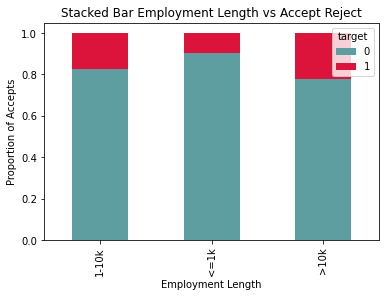

In [218]:
# Explore differentiation 
%matplotlib inline
table = pd.crosstab(df2["loan_amnt2"], df2["target"])
table.div(table.sum(1).astype(float), axis=0).plot(
    kind="bar", color=["cadetblue", "crimson"], stacked=True
)
plt.title("Stacked Bar Employment Length vs Accept Reject")
plt.xlabel("Employment Length")
plt.ylabel("Proportion of Accepts")

In [219]:
pd.crosstab(df2["loan_amnt2"], df2["target"]).apply(lambda r: r / r.sum(), axis=1)

target,0,1
loan_amnt2,,
1-10k,0.827975,0.172025
<=1k,0.904943,0.095057
>10k,0.779031,0.220969


Text(0, 0.5, 'Proportion of Accepts')

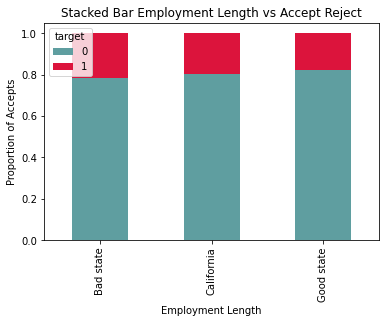

In [220]:
# Explore differentiation
%matplotlib inline
table = pd.crosstab(df2["addr_state2"], df2["target"])
table.div(table.sum(1).astype(float), axis=0).plot(
    kind="bar", color=["cadetblue", "crimson"], stacked=True
)
plt.title("Stacked Bar Employment Length vs Accept Reject")
plt.xlabel("Employment Length")
plt.ylabel("Proportion of Accepts")

In [221]:
pd.crosstab(df2["addr_state2"], df2["target"]).apply(lambda r: r / r.sum(), axis=1)

target,0,1
addr_state2,,
Bad state,0.786136,0.213864
California,0.801519,0.198481
Good state,0.822360,0.177640


In [222]:
df2

,id,target,loan_amnt2,addr_state2
0,139076511,0,>10k,Good state
2,1469880,0,1-10k,Good state
3,76014793,1,>10k,Bad state
4,71775585,1,>10k,Bad state
5,61394422,0,>10k,Bad state
...,...,...,...,...
99994,71815286,1,>10k,Good state
99995,63957199,0,1-10k,Bad state
99996,9048048,0,>10k,Bad state
99998,24616854,0,1-10k,Bad state


In [223]:
# One hot encoding
modelling_variables = ["target", "loan_amnt2", "addr_state2"]

for i in modelling_variables:
    if i != "target":
        df2 = df2.join(pd.get_dummies(df2[i]))
        df2 = df2.drop([i], axis=1)

In [225]:
# Drop Null Band
df3 = df2.drop(
    columns=[
        "1-10k",
        "California"
    ]
)

In [226]:
X = df3.loc[:, df3.columns != "target"]
y = df3.loc[:, df3.columns == "target"]

In [227]:
# Balance the data
os = RandomUnderSampler(sampling_strategy=0.5, random_state=7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
columns = X_train.columns

In [228]:
# Train
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=["target"])

# we can check the numbers of our data
print(
    "The number of observations in Development data before undersampling is ",
    len(X_train),
)
print(
    "The number of observations in Development data after undersampling is ",
    len(os_data_X),
)

The number of observations in Development data before undersampling is  41699
The number of observations in Development data after undersampling is  24948


In [229]:
# Keep only columns for modelling
os_data_X_2 = os_data_X[["<=1k", ">10k", "Good state", "Bad state"]]
X_test_2 = X_test[["<=1k", ">10k", "Good state", "Bad state"]]

In [230]:
# Build Logistic regression
# Statmodels
logit_model = sm.Logit(os_data_y, os_data_X_2.astype(float))
result3 = logit_model.fit()
print(result3.summary2())

Optimization terminated successfully.
         Current function value: 0.643687
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.011    
Dependent Variable: target           AIC:              32125.3886
Date:               2020-10-30 09:59 BIC:              32157.8868
No. Observations:   24948            Log-Likelihood:   -16059.   
Df Model:           3                LL-Null:          -15880.   
Df Residuals:       24944            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
<=1k         -1.1858    0.2918   -4.0644  0.0000  -1.7577  -0.6140
>10k          0.0413    0.0244    1.6889  0.0912  -0.0066   0.

Accuracy score Logistic Regression: 0.797157405853058


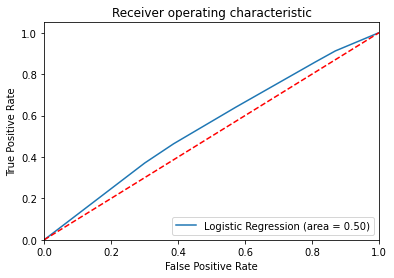

In [231]:
# Sklearn
logreg = LogisticRegression()
logreg.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = logreg.predict(X_test_2)
print("Accuracy score Logistic Regression:", logreg.score(X_test_2, y_test))
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_2))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_2)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("Log_ROC")
plt.show()

In [232]:
# Merge actual and predicted

y_hats = logreg.predict(X_test_2)
y_hats = pd.DataFrame(y_hats)

df_out = X_test_2.reset_index()
df_out["Actual"] = y_test.reset_index()["target"]
df_out["Prediction"] = y_hats.reset_index()[0]
y_test["prediction"] = y_hats

df_out = pd.merge(
    df, y_test[["prediction"]], how="left", left_index=True, right_index=True
)

df_out

,id,target,loan_amnt,addr_state,loan_amnt2,addr_state2,prediction
0,139076511,0,20000.0,SC,>10k,Good state,NaN
2,1469880,0,1600.0,CT,1-10k,Good state,0.0
3,76014793,1,32000.0,MO,>10k,Bad state,0.0
4,71775585,1,28425.0,PA,>10k,Bad state,NaN
5,61394422,0,26000.0,PA,>10k,Bad state,NaN
...,...,...,...,...,...,...,...
99994,71815286,1,25000.0,VA,>10k,Good state,NaN
99995,63957199,0,8000.0,FL,1-10k,Bad state,NaN
99996,9048048,0,20000.0,NY,>10k,Bad state,NaN
99998,24616854,0,6000.0,MD,1-10k,Bad state,NaN


In [29]:
# Predictions on the test set


,count
prediction,
0,17871


In [233]:
# Remove NaNs (Null Band + non-test set)
df_out.dropna(subset=["prediction"], inplace=True)

In [234]:
# Preprocessing for creating DF
df_out["count"] = df_out.groupby(["target", "prediction"])["target"].transform("count")
df_out2 = df_out[["prediction", "target", "count"]]
df_out3 = df_out2.drop_duplicates()
df_out3.reset_index(drop=True, inplace=True)

In [235]:
# Create "book example" dataframe
df_out3["target_0"] = df_out3.apply(
    lambda row: row["count"] if row["target"] == 0 else np.nan, axis=1
)
df_out3["target_1"] = df_out3.apply(
    lambda row: row["count"] if row["target"] == 1 else np.nan, axis=1
)
df_target_0 = df_out3[["prediction", "target_0"]]
df_target_1 = df_out3[["prediction", "target_1"]]
df_target_0.dropna(inplace=True)
df_target_1.dropna(inplace=True)
df_out4 = pd.merge(df_target_0, df_target_1, on="prediction")

In [236]:
# Rename columns
df_out4.rename(columns={"target_0": "Good", "target_1": "Bad"}, inplace=True)
# Create percentages
df_out4["Perc_Good"] = df_out4["Good"] / (df_out4["Good"] + df_out4["Bad"])
df_out4["Perc_Bad"] = df_out4["Bad"] / (df_out4["Good"] + df_out4["Bad"])

In [237]:
df_out4

,prediction,Good,Bad,Perc_Good,Perc_Bad
0,0.0,2484.0,644.0,0.794118,0.205882


## Apply the KGB Model (Logistic Regression) to the Rejects

In [243]:
# Sampling
rejected_small = rejected.sample(n=100000, random_state=7)
rejected_small.reset_index(drop=True, inplace=True)
rejected_small.rename(columns={"Amount Requested": "loan_amnt"}, inplace=True)
rejected_small.rename(columns={"State": "addr_state"}, inplace=True)
dfr = rejected_small[["loan_amnt", "addr_state"]]

In [247]:
# Q&D Bucketing
dfr["loan_amnt2"] = dfr["loan_amnt"].apply(
    lambda x: "<=1k"
    if (x <= 1000)
    else ("1-10k" if (x > 1000 and x <= 10000) else ">10k")
)

dfr["addr_state2"] = dfr["addr_state"].apply(
    lambda x: "California"
    if (x == "CA")
    else ("Bad state" if (x in badstates) else "Good state")
)

In [250]:
# One hot encoding
modelling_variables = ["target", "loan_amnt2", "addr_state2"]

for i in modelling_variables:
    if i != "target":
        dfr = dfr.join(pd.get_dummies(dfr[i]))
        dfr = dfr.drop([i], axis=1)

In [252]:
# Drop Null Band
dfr2 = dfr.drop(columns=["loan_amnt", "addr_state", "1-10k", "California"])

In [283]:
# Predictions
rej_test_predictions = logreg.predict_proba(dfr2)[:,1]
df_pred_rej = pd.DataFrame(data=rej_test_predictions, columns=["prediction"])
df_pred_rej["Rejects"] = df_pred_rej.groupby("prediction")["prediction"].transform(
    "count"
)
df_pred_rej.groupby(["prediction"]).count()

,Rejects
prediction,
0.138238,4134
0.153795,663
0.167541,1833
0.260789,32169
0.285567,6196
0.306821,15476
0.330913,22958
0.359117,4860
0.382910,11711


### Reject Inference: Simple Augmentation

In [308]:
#Reject Inference with cutoff 0.2
df_pred_rej["prediction2"] = df_pred_rej["prediction"].apply(
    lambda x: 0
    if (x < 0.2) else 1)
df_pred_rej2 = df_pred_rej["prediction2"]
ri1 = pd.DataFrame(data=df_pred_rej2, columns=["prediction2"])
ri1.rename(columns={"prediction2": "prediction"}, inplace=True)

In [295]:
ri1

,prediction
0,1
1,1
2,1
3,1
4,1
...,...
99995,0
99996,1
99997,1
99998,1


### K-Means

to-do:
- grid search/hypterparameter optimization

In [296]:
kmeans = KMeans(init="random", n_clusters=2, n_init=10, max_iter=300, random_state=7)

In [297]:
kmodel = kmeans.fit(dfr3)

In [298]:
kmeans.inertia_

5677.706839400686

In [299]:
kmeans.cluster_centers_

array([[ 1.00000000e+00, -8.43769499e-15],
       [-7.51620988e-14,  1.43633961e-01]])

In [300]:
kmeans.n_iter_

2

In [301]:
kmeans.labels_

array([0, 1, 0, ..., 1, 0, 1])

In [304]:
# Predictions
rej_test_predictions_kmeans = kmeans.labels_
df_pred_rej_kmeans = pd.DataFrame(
    data=rej_test_predictions_kmeans, columns=["prediction"]
)
df_pred_rej_kmeans["Rejects"] = df_pred_rej_kmeans.groupby("prediction")[
    "prediction"
].transform("count")
#df_pred_rej_kmeans.groupby(["prediction"]).count()

,Rejects
prediction,
0,53841
1,46159


### Reject Inference K-means

In [312]:
ri2 = pd.DataFrame(data=df_pred_rej_kmeans, columns=["prediction"])
ri2

,prediction
0,0
1,1
2,0
3,0
4,1
...,...
99995,1
99996,0
99997,1
99998,0


In [326]:
###Tests

### OPTICS

In [88]:
from sklearn.cluster import OPTICS

In [89]:
clustering = OPTICS(min_samples=2).fit(dfr3)
clustering.labels_

array([0, 1, 0, ..., 1, 0, 1])

In [91]:
clustering_optics

,prediction,Rejects
0,0,53841
1,1,39529
2,0,53841
3,0,53841
4,1,39529
...,...,...
99995,2,6630
99996,0,53841
99997,1,39529
99998,0,53841


In [90]:
# Predictions
clustering_optics = clustering.labels_
clustering_optics = pd.DataFrame(
    data=clustering_optics, columns=["prediction"]
)
clustering_optics["Rejects"] = clustering_optics.groupby("prediction")[
    "prediction"
].transform("count")
clustering_optics.groupby(["prediction"]).count()

,Rejects
prediction,
0,53841
1,39529
2,6630


### MeanShift

In [92]:
from sklearn.cluster import MeanShift

In [93]:
clustering2 = MeanShift(bandwidth=2).fit(dfr3)
clustering2.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [94]:
# Predictions
clustering_meanshift = clustering2.labels_
clustering_meanshift = pd.DataFrame(
    data=clustering_meanshift, columns=["prediction"]
)
clustering_optics["Rejects"] = clustering_meanshift.groupby("prediction")[
    "prediction"
].transform("count")
clustering_meanshift.groupby(["prediction"]).count()

""
prediction
0


### SVM

In [61]:
# Accepts
clf = SVC(gamma="auto", kernel="linear")
clf.fit(os_data_X_2, os_data_y.values.ravel())
pred = clf.predict(X_test_2)

In [62]:
# Predictions
rej_test_predictions_kmeans = clf.predict(dfr3)
df_pred_rej_kmeans = pd.DataFrame(
    data=rej_test_predictions_kmeans, columns=["prediction"]
)
df_pred_rej_kmeans["Rejects"] = df_pred_rej_kmeans.groupby("prediction")[
    "prediction"
].transform("count")
df_pred_rej_kmeans.groupby(["prediction"]).count()

,Rejects
prediction,
0,100000
